# Apache Spark in Python

In this tutorial, you will learn how to use Apache Spark to process large scale datasets. We will cover the following:

- Comparing run time of Pyspark with other statistical software packages
- Spark APIs: RDD, Dataset and Dataframes
- Loading External Datasets 
- Creating DataFrames in spark
- Comparison between Pandas and Spark DataFrame
- Transformations and Actions

# Table of Contents
- [Python Setup](#Python Setup)
- [About the Dataset we will use](#About the Dataset we will use)
- [Spark Vs. Standard Statistical Software](#Spark Vs. Standard Statistical Software)
- [Creating DataFrames](#Creating DataFrames)
    - [Loading External Dataset](#Loading External Dataset)
    - [Tracking Spark Jobs](Tracking Spark Jobs)
- [Exploring DataFrames in Spark](#Exploring DataFrames in Spark)
    - [Exercise: Explore the data](#Exercise: Explore the data)
- [Manipulating DataFrames](#Manipulating DataFrames)
    - [Creating New Columns](#Adding Columns)
    - [Grouping Data](#Adding Columns)
    - [Merging DataFrames](#Merging DataFrames)
- [Additional Resources for Learning Spark](# Additional Resources for Learning Spark)

# Python Setup
- Back to [Table of Contents](#Table-of-Contents)

Before we begin, run the code cell below to initialize the libraries we'll be using in this tutorial. We're already familiar with `pandas` from previous tutorials. In this tutorial the focus is on using Spark. For Spark, the entry point of into all functionality in Spark is the `SparkSession` class. As such, we make sure in this setup that we import this module. ANother important class in Spark building Spark applications is the `SparkContext`. In addition to these, we will also import any other required  Spark classes.

In [1]:
# utility libraries
import os
from functools import wraps
import time

# data processing libraries
import pandas as pd
import numpy as np

# Apache Spark Modules
import findspark # on windows computer, uncomment this line
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext

# plotting library
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth":1.25, "lines.markersize":8})

# About the Dataset
Unfrotunately I cannot provide granular details about the data because it is from my previous client who I did some work for when I was freelancing as a Data Scientist. In summary, the dataset is about status of some machines which the company was monitoring. In the `activity_log_raw.csv`, what you have is activity status of machines at different locations (the column *SID* represents this location/site). Also, the `STATUS` column is some kind of indicator of the health of the machine. In another dataset `outage_log_raw.csv`, it records which of the machines went offline (outages). 

> The objective of the project was to predict in advance if a machine is going to fail-this is called predictive maintainance.

# Spark Vs. Standard Statistical Software
- Back to [Table of Contents](#Table-of-Contents)

Recall that you did an experiment to record running time for the tasks in Execel, STATA and SPSS. Here, we will run the same tasks with Spark and compare the time.

In [2]:
def timefn(fn):
    """
    Function for recording running time of a function
    """
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print("@timefn:" + fn.__name__ + " took " + str(t2 - t1) + " seconds")
        return result
    return measure_time

In [6]:
# we add @timefn to measure execution time of the function
@timefn
def load_big_csv_with_apache_spark(big_csv=None):
    """
    A simple function which loads a CSV file using Apache Spark and
    then counts how many rows are in the file
    """
    spark = SparkSession.builder.master("local[8]").appName("data_processor").getOrCreate()
    df = spark.read.csv(big_csv, header=True)
    cnt = df.count()
    cnt_uniq = df.select('SID').distinct().count()
    print('Number of rows in big CSV file: {:,}, Number of unique activities: {}'.format(cnt,cnt_uniq))

** Exercise 1 : write your function to read the big dataset with pandas for further comparison**

In [3]:
@timefn
def load_big_csv_with_pandas(big_csv=None):
    """
    Use pandas library to load the large CSV
    """
    # Read CSV as a dataframe (df) here
    df = pd.read_csv(big_csv)
    
    # Get the total number of rows
    cnt = df.shape[0]
    print('Done with counting')
    
    # Get total number of unique activities using 'SID' column using code below
    cnt_uniq = len(list(df.SID.unique()))
    #print('Done with unique values')
    
    # Use len() function to get number of elements in the list above
    #cnt_uniq = YOUR CODE
    
    # print out the results
    print('Number of rows in big CSV file: {:,}, Number of unique activities: {}'.format(cnt,cnt_uniq))

In [7]:
# Now lets call the functions and see what we get
big_csv_file = '../../day3-big-data-processing-with-apache-spark/data/activity_log_raw.csv'

# Load data using spark
load_big_csv_with_apache_spark(big_csv=big_csv_file)

Number of rows in big CSV file: 194,710,125, Number of unique activities: 921
@timefn:load_big_csv_with_apache_spark took 179.68891382217407 seconds


In [8]:
# Load data using pandas
import datetime
start = datetime.datetime.now()
print('Pandas starting now {}'.format(start.ctime()))
load_big_csv_with_pandas(big_csv=big_csv_file)

Pandas starting now Thu Jul  4 15:20:40 2019
Done with counting
Number of rows in big CSV file: 194,710,125, Number of unique activities: 921
@timefn:load_big_csv_with_pandas took 230.4409999847412 seconds


** Report on what you find**

# Creating DataFrames with Apache Spark
---------------------------------------------------------------------
- Back to [Table of Contents](#Table-of-Contents)

As mentioned in the powerpoint slides, we will use the Spark DataFrame API as our main vehicle to interact with the Spark engine. In order to use a dataframe, we first need to create a Spark dataframe object. They are many ways to achieve this depending on your use case but the common ones include:
   - Loading data from external sources : Spark acceps almost any format of data, see graphic below.
   - Loading data from existing RDD: If you start with an RDD, you can convert it to a dataframe
   - Programmatically specifying schema and using Python data types

We will explore some of thes ways of creating a dataframe.

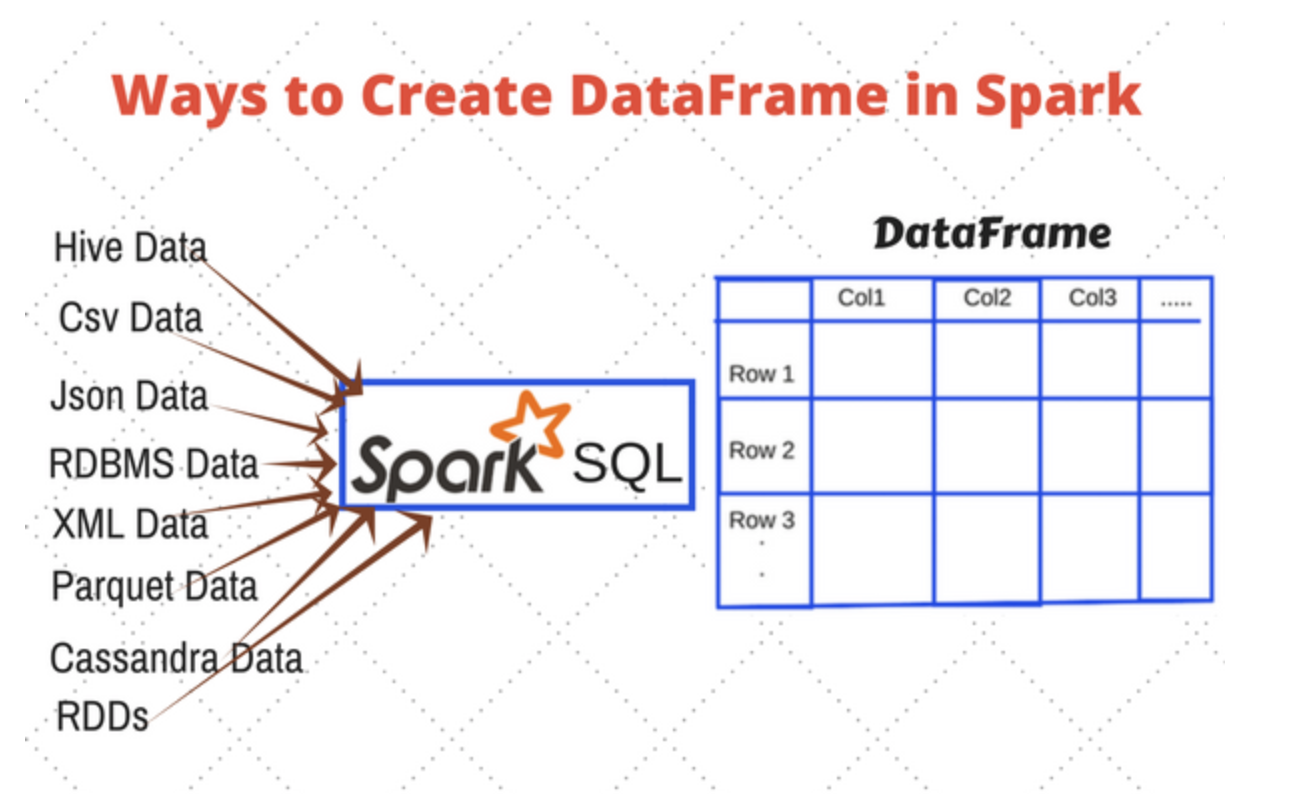

In [6]:
from IPython.display import Image
Image("../other-resources/external-data-sources.png")

## Loading Data from External Sources-CSV file
We will load our practice datasets here. Spark has a DataReader function for loading data. For CSV, you can specify whether the data has headers or not and many other parameters.

In [20]:
# In spark, we alwsys need to create a sparkSession object first as below, then we use it
spark = SparkSession.builder.master("local[8]").appName("data_processor").getOrCreate()

In [21]:
# Loading the dataset
big_csv_file = '../../day3-big-data-processing-with-apache-spark/data/activity_log_raw.csv'
sdf = spark.read.csv(big_csv_file, header=True)

**Exercise 2: Using the dir() function, check what methods/functions are available for a dataframe object**
- print out the functions
- Using the sysntax `df.method?` find help about the following methods
    - describe
    - count
    - summary
    

In [23]:
sdf.count()

194710125

In [ ]:
cnt_uniq = sdf.select('SID').distinct().count()

## Tracking Spark Jobs
If you go to the url `localhost/4040/` you will see there is a spark UI which shows you progress of you jobs.
This is a very useful facility because it shows you status of your jobs. For instance, you ccan chek if the job is stuck. Also, you can kill the job on this UI.

In [15]:
# Using the dir() function, check what methods are available for the dataframe object
print(dir(sdf))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_collectAsArrow', '_jcols', '_jdf', '_jmap', '_jseq', '_lazy_rdd', '_sc', '_schema', '_sort_cols', 'agg', 'alias', 'approxQuantile', 'cache', 'checkpoint', 'coalesce', 'colRegex', 'collect', 'columns', 'corr', 'count', 'cov', 'createGlobalTempView', 'createOrReplaceGlobalTempView', 'createOrReplaceTempView', 'createTempView', 'crossJoin', 'crosstab', 'cube', 'describe', 'distinct', 'drop', 'dropDuplicates', 'drop_duplicates', 'dropna', 'dtypes', 'explain', 'fillna', 'filter', 'first', 'foreach', 'foreachPartition', 'freqItems', 'groupBy', 'groupby', 'head', 'hint', 'intersect', 'isLocal', 'isStreaming', 'is_cached', 

In [11]:
sdf.head()

Row(SID='584', ACTIVITY_ID='1291', ACTIVITY_TIME='13-APR-15 10.33.42.190000000 PM', STATUS='S')

In [16]:
# You can get help on each method by using this sysntax
sdf.select?

# Exploring DataFrames in Spark

- Back to [Table of Contents](#Table-of-Contents)

We can do the similar things we did with pandas dataframes in order to explore the data.
- We can use the `printSchema()` function to check column data types as well as what kind of columns we have.
- Also, you can use the the same `columns` function to get a list of all columns
- We can use `head()` function just like in pandas to get the top `n` observations from the data. Note that you can use n within the brackets in the head function to specify the number of rows you want to see.
- Count the number of rows in the dataframe using the `count()` function
- Get number of unique elements using `distinct()` command. If you want number of unique elements based on a single column. You can first select the column using the sysntax `df.select("column").distinct().count()`


## Exercise 3: Explore the data
- Use head() function to view the first 5 observations
- Check column data types
- Get total number of rows
- How many unique categories are there for the STATUS variable?
- Using the documentation for [Pyspark DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) find a function to get a sample of the data. Get a sample of 10% of the data and convert it to a pandas dataframe using `toPandas()` function
- Attempt to use `summary()` function on the dataframe. Once you call the function, open the spakr UI by going to this *localhost/4040*

In [26]:
sdf.head()

Row(SID='584', ACTIVITY_ID='1291', ACTIVITY_TIME='13-APR-15 10.33.42.190000000 PM', STATUS='S')

In [ ]:
sample = sdf.sample(fraction=0.0001).toPandas()

# Manipulating DataFrames

- Back to [Table of Contents](#Table-of-Contents)

Once you have explored the data, the next thing you would want to do is do some manipulations. They are many things we do to manipulate data. Some of the manipulations include the following:
- **Work on Columns**: rename, select columns, change data type, drop columns, create new column based on values of other columns
- ** Work on Rows**: Select rows based on condition

## Working with  Columns

### Rename Columns
Use the `dataframe.withColumnRenamed()` function to achive this. Note that the function returns a new dataframe object.

In [29]:
sdf.columns

['SID', 'ACTIVITY_ID', 'ACTIVITY_TIME', 'STATUS']

In [33]:
# Rename the rest of the columns to small letters
sdf3 = sdf2.withColumnRenamed('ACTIVITY_ID', 'act_id').withColumnRenamed('ACTIVITY_TIME','datetime').withColumnRenamed('STATUS','status')

In [35]:
sdf3.head()

Row(site_id='584', act_id='1291', datetime='13-APR-15 10.33.42.190000000 PM', status='S')

### Change Column Data Type and Create New Column
Note that we have the *ACTIVITY_TIME* variable but we cant do much with it now because its just a string.
Therefore, we cant do date/time operations on a string. If we need to check the dates and do date manipulations, we need to change the data type of the column to date/time.

In [36]:
# Lets double check the data types
sdf3.printSchema()

root
 |-- site_id: string (nullable = true)
 |-- act_id: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- status: string (nullable = true)



##### Lets check available date/time data types in Spark
Head over to Spark documentation and check data types

In [32]:
sdf.printSchema()

root
 |-- SID: string (nullable = true)
 |-- ACTIVITY_ID: string (nullable = true)
 |-- ACTIVITY_TIME: string (nullable = true)
 |-- STATUS: string (nullable = true)



In [39]:
# Lets check the time format
sdf3.head(1)

[Row(site_id='584', act_id='1291', datetime='13-APR-15 10.33.42.190000000 PM', status='S')]

In [40]:
from datetime import datetime

In [41]:
date = datetime.now()
type(date)

datetime.datetime

In [42]:
date.ctime()

'Fri Mar 15 17:46:00 2019'

In [43]:
# we need ot import another spark module to achieve what we want to do
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
from datetime import datetime

# Create a Spark User Defined Function(UDF) to add date and datetime which has a date format parameter
date_fmt = '%d-%b-%y %H.%M.%S %p'
add_datetime = udf(lambda x: datetime.strptime(x[:18] +' '+ x[-2:], date_fmt), TimestampType())
add_date = udf(lambda x: datetime.strptime(x[:18] +' '+ x[-2:], date_fmt), DateType())

The statements below are *transformations* on the dataframe. Therefore, spark doesn't do anything until we call 
an action such as `head()`. This means that if there is an error in the code in the cell below, you will not know until you run a code which is taking an action. We can try this: introduce an error in the code.

In [45]:
# add datetime
sdf4 = sdf3.withColumn('datetime2', add_datetime(col('datetime')))

# add date
sdf5 = sdf4.withColumn('date', add_date(col('datetime')))

In [47]:
# Lets check if the transformations worked
sdf4.head(1)

[Row(site_id='584', act_id='1291', datetime='13-APR-15 10.33.42.190000000 PM', status='S', datetime2=datetime.datetime(2015, 4, 13, 10, 33, 42))]

In [53]:
sd4.printSchema()

root
 |-- site_id: string (nullable = true)
 |-- ACTIVITY_ID: string (nullable = true)
 |-- ACTIVITY_TIME: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- date: date (nullable = true)



## Analysing Data

# EXERCISE
---------------------------------

# Question 1: Change 'ACTIVITY_ID' to a integer data type
The syntax is like so:  `withColumn('new column name, df.old_column_name.cast(new_data_type())`. 
Note that they are two ways to reference colums in Spark: `df.column or df[colum]`. Use `IntegerType()` for data type. Check the new df after this transformation.